In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

'Amenity Detection'    colab		 'Getting started.pdf'
'Car Classification'  'Colab Notebooks'   LicensePlateDetector


**Make Prediction**

In [0]:
net = cv2.dnn.readNetFromDarknet('/mydrive/LicensePlateDetector/backup/yolov3_custom_train.cfg', '/mydrive/LicensePlateDetector/backup/yolov3_custom_train_1800.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)   #GPU = cv2.dnn.DNN_TARGET_OPENCL_FP16, CPU = DNN_TARGET_CPU

In [0]:
inpWidth = 416  #608     #Width of network's input image
inpHeight = 416 #608     #Height of network's input image
confThreshold = 0.6  #Confidence threshold
nmsThreshold = 0.5  #Non-maximum suppression threshold

classes = ['LicensePlate']   #This is the class labels

In [0]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [0]:
# Draw the predicted bounding box
def drawPred(frame, classId, conf, left, top, right, bottom):

    # get cropped LP
    crop_img = frame[top:bottom, left:right]
    cv2_imshow(crop_img)
    print(crop_img.shape)

    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)


    print('from drawpred')
    cv2_imshow(frame)

In [0]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)

In [0]:
def main_generate_prediction(input_path, output_path):
    if input_path != 'webcam':
      file_name, ext = os.path.splitext(input_path)

    # image file
    if ext.lower() == '.jpeg' or ext.lower() == '.jpg' or ext.lower() == '.png':
        cap = cv2.VideoCapture(input_path)

    # video file
    else:
        # mp4 video file
        if ext.lower() == '.mp4':
          cap = cv2.VideoCapture(input_path)
        # webcam
        else:
          cap = cv2.VideoCapture(0)

        vid_writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

    # Process Images and Video
    while cv2.waitKey(1) < 0:
      # get frame from the video
      hasFrame, frame = cap.read()

      # Stop the program if reached end of video
      if not hasFrame:
          print("Done processing !!!")
          cv2.waitKey(3000)
          break

      # Create a 4D blob from a frame.
      blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

      # Sets the input to the network
      net.setInput(blob)

      # Runs the forward pass to get output of the output layers
      outs = net.forward(getOutputsNames(net))

      # Remove the bounding boxes with low confidence
      postprocess(frame, outs)

      # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
      t, _ = net.getPerfProfile()
      label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
      print(label)

      # Write the frame with the detection boxes
      if ext.lower() == '.jpeg' or ext.lower() == '.jpg' or ext.lower() == '.png':
          cv2.imwrite(output_path, frame.astype(np.uint8));
          #cv2_imshow(frame.astype(np.uint8))
      else:
          vid_writer.write(frame.astype(np.uint8))

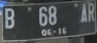

(43, 97, 3)
from drawpred


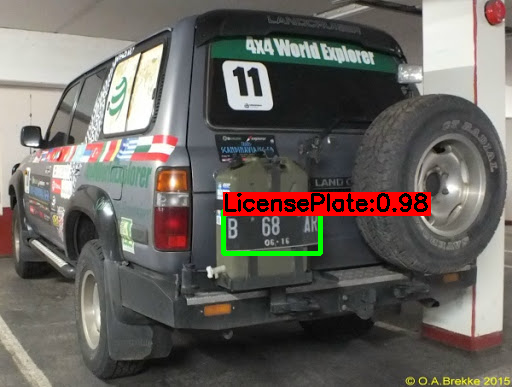

Inference time: 291.21 ms
Done processing !!!


In [76]:
main_generate_prediction('/mydrive/LicensePlateDetector/test.jpg', '/mydrive/LicensePlateDetector/prediction.jpg')

In [0]:
out = cv2.imread('/mydrive/LicensePlateDetector/test.jpg')

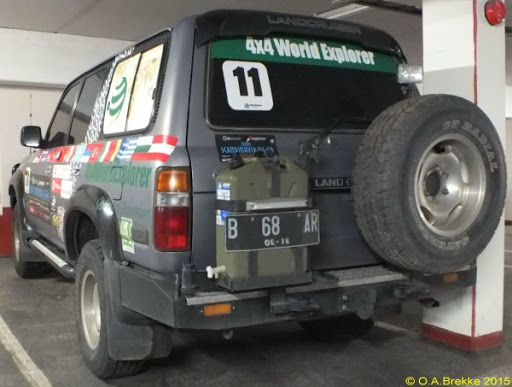

In [85]:
cv2_imshow(out.astype(np.uint8))

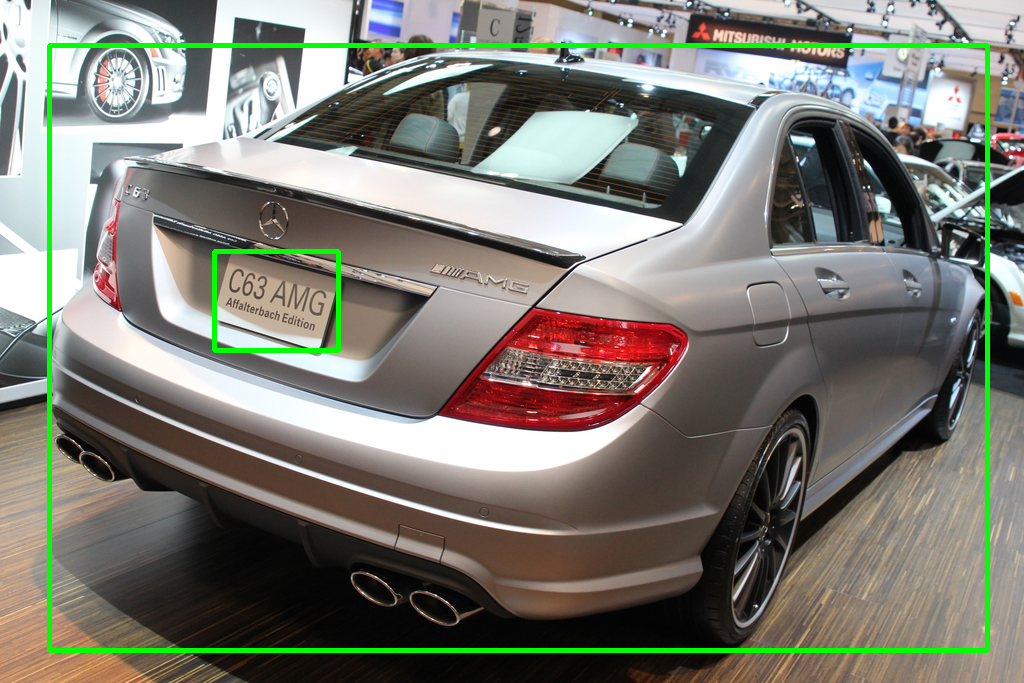

In [0]:
# truth label
im = cv2.imread('data/val/003a5aaf6d17c917.jpg')
cv2.rectangle(im, (214, 251), (338, 350), (0, 255, 0), 3)
cv2.rectangle(im, (49, 45), (987, 650), (0, 255, 0), 3)
cv2_imshow(im)